# Exercise 6 - Hyperparameter Optimization

This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow, https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ and [https://github.com/fchollet/keras/blob/master/examples/mnist_sklearn_wrapper.py]()

We want to build simple CNN models to classify the MNIST dataset and uses sklearn's GridSearchCV to find the best hyperparameter model

## Data Preparation

Let's first load and preprocess the data as we did in exercise 5: 

In [1]:
#Import the required libraries
from keras import backend as K
import numpy as np
from keras.utils import np_utils
from keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

np.random.seed(1338)  # for reproducibilty!!

# input image dimensions
img_rows, img_cols = 28, 28
# number of classes
nb_classes = 10

#Data format
if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)
    
#Load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Scale the data and concert to data format
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],img_rows*img_cols))
X_test = scaler.transform(X_test.reshape(X_test.shape[0],img_rows*img_cols))
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

#convert target vector
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Take just 20k example for training for speed reasons
X_train = X_train[:20000]
Y_train = Y_train[:20000]

/media/nackenho/Data/programs/ML/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## How to use Keras Models in scikit-learn
Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.

To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.

You can learn more about the scikit-learn wrapper in Keras API documentation:

https://keras.io/scikit-learn-api/

## Build Model
We will define a function which builds a similar model we used in exercise 5, but depends on all hyperparameter we would like to tune:

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
def make_model(dense_layer_sizes, dense_activation, filters, 
               kernel_size, pool_size, padding_type, stride_size, dropout_rate, optimizer):
    '''Creates model comprised of 2 convolutional layers followed by dense layers

    dense_layer_sizes: List of layer sizes. This list has one number for each layer
    dense_activation: activation funciton in dense layer
    filters: Number of convolutional filters in each convolutional layer
    kernel_size: Convolutional kernel size
    pool_size: Size of pooling area for max pooling
    padding_type: type of padding: same or valid
    stride_size: symmetric stride size
    dropout_rate: dropout rate
    optimizer: optimizer used for mimizing
    '''

    model = Sequential()
    
    model.add(Conv2D(filters, (kernel_size, kernel_size), padding=padding_type, 
                     strides=(stride_size, stride_size), activation='relu', input_shape=shape_ord))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation=dense_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

    return model

In [4]:
my_cnn = KerasClassifier(make_model)

**Note:** Not even all hyperparameter are included here, we are not varying things like the neural network weight initialization

`model.add(Dense(layer_size, activation=dense_activation, kernel_initializer=init_mode))` <br>
with <br>
`init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']` <br>

or we have not included kernel regularizer like l1/l2 for which we would need to change the strength. The parameter of the optimizer are also not yet included, but we will do that later.

## How to use Grid Search in scikit-learn


Grid search is a model hyperparameter optimization technique. More information on hyperparameter optimization can be found here:
http://scikit-learn.org/stable/modules/grid_search.html

In scikit-learn this technique is provided in the `GridSearchCV` class.

When constructing this class you must provide a dictionary of hyperparameters to evaluate in the param_grid argument. This is a map of the model parameter name and an array of values to try.

By default, accuracy is the score that is optimized, but other scores can be specified in the score argument of the GridSearchCV constructor.

By default, the grid search will only use one thread. By setting the n_jobs argument in the GridSearchCV constructor to -1, the process will use all cores on your machine. Depending on your Keras backend, this may interfere with the main neural network training process.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model and by default a 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.
Below is an example of defining a simple grid search:

`param_grid = dict(epochs=[10,20,30])`<br>
`grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)`<br>
`grid_result = grid.fit(X, Y)`

Once completed, you can access the outcome of the grid search in the result object returned from grid.fit(). The best_score_ member provides access to the best score observed during the optimization procedure and the best_params_ describes the combination of parameters that achieved the best results.

You can learn more about it here:

http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV


In [5]:
from sklearn.model_selection import GridSearchCV

## GridSearch HyperParameters
First we would like to optimize the convolutional part of the NN, we fix everything else and vary the filter, kernel size, pool size. We could change the padding type and the striding, but we know that padding won't have a large impact, since there is no information in the corners and we neglect striding for now.

In [6]:
dense_size_candidates = [[32]]
optimizer = ['Adam']
activation = ['relu']

param_grid={'dense_layer_sizes': dense_size_candidates,
            'dense_activation' : activation,
             'filters': [16, 32],
             'kernel_size': [3, 5],
             'pool_size': [2, 4],
             'padding_type' : ['valid'],
             'stride_size'  : [1],
             'dropout_rate' : [0.5],
             'optimizer' : optimizer,
             # epochs and batch_size are avail for tuning even when not
             # an argument to model building function
             'epochs': [1],
             'batch_size': [256]
              }


## ModelCheckpoint

We want to save the best model for each grid search step (we could also save all of them, of course). For that we will use the ModelCheckpoint call back function, which is also useful to save a NN model after each epoch.

In [7]:
from keras.callbacks import ModelCheckpoint

filepath = "best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

## Run the grid search

We will use cross-validation with k=2 (speed) and `average precision` as a score value to find the best parameter set. The best metric for optimization depends on your problem, you can find a built-in list here:<br>
http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter<br>
But you can also define your own scoring function:<br>
http://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions

In [8]:
grid = GridSearchCV(my_cnn, param_grid, cv=2, scoring='average_precision', n_jobs=1)
grid_result = grid.fit(X_train, Y_train, callbacks=[checkpoint])

Epoch 1/1
10000/10000 [==============================] - 2s 232us/step - loss: 1.6526 - acc: 0.4386

Epoch 00001: acc improved from -inf to 0.43860, saving model to best_cnn.hdf5
Epoch 1/1
10000/10000 [==============================] - 2s 227us/step - loss: 1.8641 - acc: 0.3450

Epoch 00001: acc did not improve from 0.43860
Epoch 1/1
10000/10000 [==============================] - 2s 175us/step - loss: 2.1803 - acc: 0.2091

Epoch 00001: acc did not improve from 0.43860
Epoch 1/1
10000/10000 [==============================] - 2s 183us/step - loss: 2.1643 - acc: 0.2233

Epoch 00001: acc did not improve from 0.43860
Epoch 1/1
10000/10000 [==============================] - 3s 289us/step - loss: 1.7412 - acc: 0.4146

Epoch 00001: acc did not improve from 0.43860
Epoch 1/1
10000/10000 [==============================] - 3s 310us/step - loss: 1.7228 - acc: 0.4009

Epoch 00001: acc did not improve from 0.43860
Epoch 1/1
10000/10000 [==============================] - 3s 269us/step - loss: 2.1662 

In [9]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.921226 using {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adam', 'kernel_size': 5}
0.897022 (0.013736) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 16, 'optimizer': 'Adam', 'kernel_size': 3}
0.697076 (0.006241) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 4, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 16, 'optimizer': 'Adam', 'kernel_size': 3}
0.894810 (0.001824) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 16, 'optimizer': 'Adam', 'kernel_size': 5}
0.704866 (0.0

## Task 1: Perform a sequentiell grid search to optimze the following hyperparameter. Save the best model for each of the sequentiell steps into a hdf5 file.
* Find the best optimizer: `'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'`
* Find the best dense structure: Change the width and the depth and try at least 4 different structures
* Find the best activation function for the dense network `'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'`
* Find the best dropout rate: Change dropout between 0 and 0.5 in 0.1 steps
* Find the best optimizer parameter: In order to do that, you need to change the make_model function to adapt for that. Vary the parameter in a meaningful range.

## Change the optimizer

In [10]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid={'dense_layer_sizes': dense_size_candidates,
            'dense_activation' : activation,
             'filters': [32],
             'kernel_size': [5],
             'pool_size': [2],
             'padding_type' : ['valid'],
             'stride_size'  : [1],
             'dropout_rate' : [0.5],
             'optimizer' : optimizer,
             # epochs and batch_size are avail for tuning even when not
             # an argument to model building function
             'epochs': [1],
             'batch_size': [256]
              }

In [11]:
filepath = "best_optimizer.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

grid = GridSearchCV(my_cnn, param_grid, cv=2, scoring='average_precision', n_jobs=1)
grid_result = grid.fit(X_train, Y_train, callbacks=[checkpoint])

Epoch 1/1
10000/10000 [==============================] - 4s 441us/step - loss: 2.2812 - acc: 0.1367

Epoch 00001: acc improved from -inf to 0.13670, saving model to best_optimizer.hdf5
Epoch 1/1
10000/10000 [==============================] - 4s 438us/step - loss: 2.2716 - acc: 0.1514

Epoch 00001: acc improved from 0.13670 to 0.15140, saving model to best_optimizer.hdf5
Epoch 1/1
10000/10000 [==============================] - 9s 896us/step - loss: 1.4214 - acc: 0.5328

Epoch 00001: acc improved from 0.15140 to 0.53280, saving model to best_optimizer.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 624us/step - loss: 1.4039 - acc: 0.5428

Epoch 00001: acc improved from 0.53280 to 0.54280, saving model to best_optimizer.hdf5
Epoch 1/1
10000/10000 [==============================] - 5s 519us/step - loss: 1.1625 - acc: 0.6008

Epoch 00001: acc improved from 0.54280 to 0.60080, saving model to best_optimizer.hdf5
Epoch 1/1
10000/10000 [==============================] - 7s 685

In [12]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.953131 using {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.432478 (0.031058) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 32, 'optimizer': 'SGD', 'kernel_size': 5}
0.919020 (0.007165) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 32, 'optimizer': 'RMSprop', 'kernel_size': 5}
0.953131 (0.003355) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.917

## Change the dense structure

In [13]:
optimizer = ['Adagrad']
dense_size_candidates = [[32], [64], [32, 32], [64, 64]]

param_grid={'dense_layer_sizes': dense_size_candidates,
            'dense_activation' : activation,
             'filters': [32],
             'kernel_size': [5],
             'pool_size': [2],
             'padding_type' : ['valid'],
             'stride_size'  : [1],
             'dropout_rate' : [0.5],
             'optimizer' : optimizer,
             # epochs and batch_size are avail for tuning even when not
             # an argument to model building function
             'epochs': [1],
             'batch_size': [256]
           }

In [14]:
filepath = "best_dnnstruc.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

grid = GridSearchCV(my_cnn, param_grid, cv=2, scoring='average_precision', n_jobs=1)
grid_result = grid.fit(X_train, Y_train, callbacks=[checkpoint])

Epoch 1/1
10000/10000 [==============================] - 6s 587us/step - loss: 1.1246 - acc: 0.6261

Epoch 00001: acc improved from -inf to 0.62610, saving model to best_dnnstruc.hdf5
Epoch 1/1
10000/10000 [==============================] - 5s 524us/step - loss: 1.2111 - acc: 0.5962

Epoch 00001: acc did not improve from 0.62610
Epoch 1/1
10000/10000 [==============================] - 6s 565us/step - loss: 0.8494 - acc: 0.7286

Epoch 00001: acc improved from 0.62610 to 0.72860, saving model to best_dnnstruc.hdf5
Epoch 1/1
10000/10000 [==============================] - 7s 683us/step - loss: 1.0527 - acc: 0.6630

Epoch 00001: acc did not improve from 0.72860
Epoch 1/1
10000/10000 [==============================] - 6s 627us/step - loss: 1.3466 - acc: 0.5412

Epoch 00001: acc did not improve from 0.72860
Epoch 1/1
10000/10000 [==============================] - 6s 565us/step - loss: 1.3039 - acc: 0.5483 3s - loss: 1.

Epoch 00001: acc did not improve from 0.72860
Epoch 1/1
10000/10000 [====

In [15]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.972087 using {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.954223 (0.001573) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.972087 (0.003852) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.948875 (0.001103) with: {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [32, 32], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 

## Change the dense activation

In [16]:
optimizer = ['Adagrad']
dense_size_candidates = [[64]]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

param_grid={'dense_layer_sizes': dense_size_candidates,
            'dense_activation' : activation,
             'filters': [32],
             'kernel_size': [5],
             'pool_size': [2],
             'padding_type' : ['valid'],
             'stride_size'  : [1],
             'dropout_rate' : [0.5],             
             'optimizer' : optimizer,
             # epochs and batch_size are avail for tuning even when not
             # an argument to model building function
             'epochs': [1],
             'batch_size': [256]
              }

In [17]:
filepath = "best_dnnact.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

grid = GridSearchCV(my_cnn, param_grid, cv=2, scoring='average_precision', n_jobs=1)
grid_result = grid.fit(X_train, Y_train, callbacks=[checkpoint])

Epoch 1/1
10000/10000 [==============================] - 6s 575us/step - loss: 2.0666 - acc: 0.3660

Epoch 00001: acc improved from -inf to 0.36600, saving model to best_dnnact.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 585us/step - loss: 2.0557 - acc: 0.4155

Epoch 00001: acc improved from 0.36600 to 0.41550, saving model to best_dnnact.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 600us/step - loss: 0.9658 - acc: 0.6856

Epoch 00001: acc improved from 0.41550 to 0.68560, saving model to best_dnnact.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 569us/step - loss: 1.0423 - acc: 0.6630

Epoch 00001: acc did not improve from 0.68560
Epoch 1/1
10000/10000 [==============================] - 6s 648us/step - loss: 0.7227 - acc: 0.7942

Epoch 00001: acc improved from 0.68560 to 0.79420, saving model to best_dnnact.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 616us/step - loss: 0.7807 - acc: 0.7758

Epoch 00001: ac

In [18]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975186 using {'dropout_rate': 0.5, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.798972 (0.016352) with: {'dropout_rate': 0.5, 'dense_activation': 'softmax', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.960227 (0.003834) with: {'dropout_rate': 0.5, 'dense_activation': 'softplus', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.972510 (0.002323) with: {'dropout_rate': 0.5, 'dense_activation': 'softsign', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_

## Change the dropout rate

In [19]:
optimizer = ['Adagrad']
dense_size_candidates = [[64]]
activation = ['relu']

param_grid={'dense_layer_sizes': dense_size_candidates,
            'dense_activation' : activation,
             'filters': [32],
             'kernel_size': [5],
             'pool_size': [2],
             'padding_type' : ['valid'],
             'stride_size'  : [1],
             'dropout_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
             'optimizer' : optimizer,
             # epochs and batch_size are avail for tuning even when not
             # an argument to model building function
             'epochs': [1],
             'batch_size': [256]
              }

In [20]:
filepath = "best_dropout.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

grid = GridSearchCV(my_cnn, param_grid, cv=2, scoring='average_precision', n_jobs=1)
grid_result = grid.fit(X_train, Y_train, callbacks=[checkpoint])

Epoch 1/1
10000/10000 [==============================] - 7s 699us/step - loss: 0.7614 - acc: 0.7725

Epoch 00001: acc improved from -inf to 0.77250, saving model to best_dropout.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 640us/step - loss: 0.7525 - acc: 0.7619

Epoch 00001: acc did not improve from 0.77250
Epoch 1/1
10000/10000 [==============================] - 6s 619us/step - loss: 0.6616 - acc: 0.7915

Epoch 00001: acc improved from 0.77250 to 0.79150, saving model to best_dropout.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 615us/step - loss: 0.7723 - acc: 0.7703

Epoch 00001: acc did not improve from 0.79150
Epoch 1/1
10000/10000 [==============================] - 7s 665us/step - loss: 0.7761 - acc: 0.7571

Epoch 00001: acc did not improve from 0.79150
Epoch 1/1
10000/10000 [==============================] - 6s 614us/step - loss: 0.7375 - acc: 0.7693

Epoch 00001: acc did not improve from 0.79150
Epoch 1/1
10000/10000 [====================

In [21]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975560 using {'dropout_rate': 0.2, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.962235 (0.000827) with: {'dropout_rate': 0.1, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.975560 (0.004739) with: {'dropout_rate': 0.2, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0.970889 (0.001845) with: {'dropout_rate': 0.3, 'dense_activation': 'relu', 'padding_type': 'valid', 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'optimizer': 'Adagrad', 'kernel_size': 5}
0

## Change the optimizer parameter

In [22]:
from keras.optimizers import Adam

def make_model(dense_layer_sizes, dense_activation, filters, 
               kernel_size, pool_size, padding_type, stride_size, dropout_rate, learn_rate, beta_1, beta_2, decay):
    '''Creates model comprised of 2 convolutional layers followed by dense layers

    dense_layer_sizes: List of layer sizes. This list has one number for each layer
    dense_activation: activation funciton in dense layer
    filters: Number of convolutional filters in each convolutional layer
    kernel_size: Convolutional kernel size
    pool_size: Size of pooling area for max pooling
    padding_type: type of padding: same or valid
    stride_size: symmetric stride size
    dropout_rate: dropout rate
    optimizer: optimizer used for mimizing
    '''
    
    optimizer = Adam(lr=learn_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)

    model = Sequential()
    
    model.add(Conv2D(filters, (kernel_size, kernel_size), padding=padding_type, 
                     strides=(stride_size, stride_size), activation='relu', input_shape=shape_ord))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation=dense_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

    return model

my_cnn = KerasClassifier(make_model)

In [23]:
dense_size_candidates = [[64]]
activation = ['relu']

param_grid={'dense_layer_sizes': dense_size_candidates,
            'dense_activation' : activation,
             'filters': [32],
             'kernel_size': [5],
             'pool_size': [2],
             'padding_type' : ['valid'],
             'stride_size'  : [1],
             'dropout_rate' : [0.2],
             # epochs and batch_size are avail for tuning even when not
             # an argument to model building function
             'epochs': [1],
             'batch_size': [256],
             'learn_rate' : [0.001, 0.0001],
             'beta_1' : [0.9, 0.8],
             'beta_2' : [0.999],
             'decay'  : [0.0, 0.3]

              }

In [24]:
filepath = "best_adampar.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

grid = GridSearchCV(my_cnn, param_grid, cv=2, scoring='average_precision', n_jobs=1)
grid_result = grid.fit(X_train, Y_train, callbacks=[checkpoint])

Epoch 1/1
10000/10000 [==============================] - 6s 608us/step - loss: 0.9922 - acc: 0.7063

Epoch 00001: acc improved from -inf to 0.70630, saving model to best_adampar.hdf5
Epoch 1/1
10000/10000 [==============================] - 6s 629us/step - loss: 0.9303 - acc: 0.7235

Epoch 00001: acc improved from 0.70630 to 0.72350, saving model to best_adampar.hdf5
Epoch 1/1
10000/10000 [==============================] - 8s 788us/step - loss: 2.0841 - acc: 0.4044

Epoch 00001: acc did not improve from 0.72350
Epoch 1/1
10000/10000 [==============================] - 7s 746us/step - loss: 2.1117 - acc: 0.4060

Epoch 00001: acc did not improve from 0.72350
Epoch 1/1
10000/10000 [==============================] - 9s 902us/step - loss: 1.6133 - acc: 0.5807

Epoch 00001: acc did not improve from 0.72350
Epoch 1/1
10000/10000 [==============================] - 7s 678us/step - loss: 1.5931 - acc: 0.6310

Epoch 00001: acc did not improve from 0.72350
Epoch 1/1
10000/10000 [====================

In [25]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.956970 using {'beta_1': 0.8, 'learn_rate': 0.001, 'dropout_rate': 0.2, 'beta_2': 0.999, 'dense_activation': 'relu', 'padding_type': 'valid', 'decay': 0.0, 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'kernel_size': 5}
0.953437 (0.001145) with: {'beta_1': 0.9, 'learn_rate': 0.001, 'dropout_rate': 0.2, 'beta_2': 0.999, 'dense_activation': 'relu', 'padding_type': 'valid', 'decay': 0.0, 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'kernel_size': 5}
0.812760 (0.012938) with: {'beta_1': 0.9, 'learn_rate': 0.0001, 'dropout_rate': 0.2, 'beta_2': 0.999, 'dense_activation': 'relu', 'padding_type': 'valid', 'decay': 0.0, 'batch_size': 256, 'pool_size': 2, 'epochs': 1, 'dense_layer_sizes': [64], 'stride_size': 1, 'filters': 32, 'kernel_size': 5}
0.866507 (0.001715) with: {'beta_1': 0.9, 'learn_rate': 0.001, 'dropout_rate': 0.2, 'beta_2': 0.999, 'dense_activation': '

## Tips for Hyperparameter Optimization
This section lists some handy tips to consider when tuning hyperparameters of your neural network.

* **k-fold Cross Validation.** You can see that the results from the examples in this post show some variance. For speed reasons, we used a cross-validation of 2, but perhaps k=5 or k=10 would be more stable. Carefully choose your cross validation configuration to ensure your results are stable.
* **Review the Whole Grid.** Do not just focus on the best result, review the whole grid of results and look for trends to support configuration decisions.
* **Parallelize.** Use all your cores if you can, neural networks are slow to train and we often want to try a lot of different parameters. Consider using cluster instances if available.
* **Use a Sample of Your Dataset.** Because networks are slow to train, try training them on a smaller sample of your training dataset, just to get an idea of general directions of parameters rather than optimal configurations.
* **Start with Coarse Grids.** Start with coarse-grained grids and zoom into finer grained grids once you can narrow the scope.
* **Do not Transfer Results.** Results are generally problem specific. Try to avoid favorite configurations on each new problem that you see. It is unlikely that optimal results you discover on one problem will transfer to your next project. Instead look for broader trends like number of layers or relationships between parameters.
* **Reproducibility is a Problem.** Although we set the seed for the random number generator in NumPy, the results are not 100% reproducible. There is more to reproducibility when grid searching wrapped Keras models than is presented in this post.

## Task 2: Load the best model and evaluate it using the function below
You can load the model using<br>
`from keras.models import load_model`<br>
`model= load_model('filename')`

In [26]:
################################################################################################### 

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
################################################################################################### 
from sklearn.metrics import confusion_matrix,classification_report

def evaluate(X_test, Y_test, model):
    
    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    Y_cls = np.argmax(Y_pred, axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test, axis = 1) 
    print 'Classification Report:\n', classification_report(Y_true,Y_cls)
    
    ## Plot 0 probability including overtraining test
    plt.figure(figsize=(8,8))

    label=0
    #Test prediction
    Y_pred_prob = Y_pred[:,label]
    plt.hist(Y_pred_prob[Y_true == label], alpha=0.5, color='red', range=[0, 1], bins=10, log = True)
    plt.hist(Y_pred_prob[Y_true != label], alpha=0.5, color='blue', range=[0, 1], bins=10, log = True)
    #Train prediction
    Y_train_pred = model.predict(X_train)
    Y_train_pred_prob = Y_train_pred[:,label]
    Y_train_true = np.argmax(Y_train, axis = 1) 
    plt.hist(Y_train_pred_prob[Y_train_true == label], alpha=0.5, color='red', range=[0, 1], bins=10, log = True, histtype='step', linewidth=2)
    plt.hist(Y_train_pred_prob[Y_train_true != label], alpha=0.5, color='blue', range=[0, 1], bins=10, log = True, histtype='step', linewidth=2)
    
    plt.legend(['train == 0', 'train != 0', 'test == 0', 'test != 0'], loc='upper right')
    plt.xlabel('Probability of being 0')
    plt.ylabel('Number of entries')
    plt.show()
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_cls) 
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(confusion_mtx, classes = range(10))

    #Plot largest errors
    errors = (Y_cls - Y_true != 0)
    Y_cls_errors = Y_cls[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_true[errors]
    X_test_errors = X_test[errors]
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    # Sorted list of the delta prob errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    # Top 6 errors 
    most_important_errors = sorted_dela_errors[-6:]
    # Show the top 6 errors
    display_errors(most_important_errors, X_test_errors, Y_cls_errors, Y_true_errors)
    
    ##Plot predictions
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)
    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test[i].reshape(28,28), interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

## Load best model and evaluate

In [27]:
from keras.models import load_model
model= load_model('best_dropout.hdf5')

('Test Loss:', 0.1721801412165165)
('Test Accuracy:', 0.95)
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.98      0.99      0.98      1135
          2       0.96      0.93      0.94      1032
          3       0.96      0.94      0.95      1010
          4       0.96      0.95      0.96       982
          5       0.94      0.95      0.95       892
          6       0.94      0.97      0.96       958
          7       0.90      0.97      0.93      1028
          8       0.96      0.89      0.92       974
          9       0.94      0.93      0.93      1009

avg / total       0.95      0.95      0.95     10000



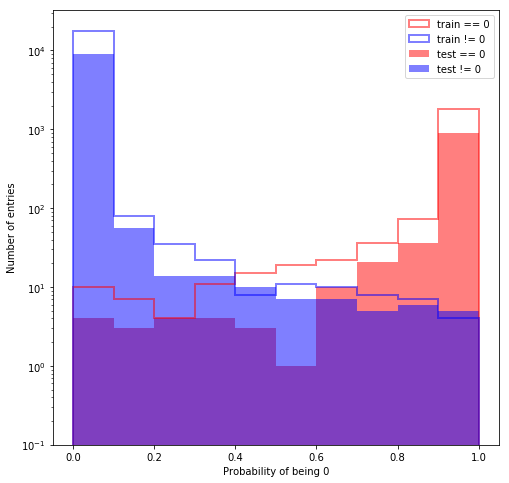

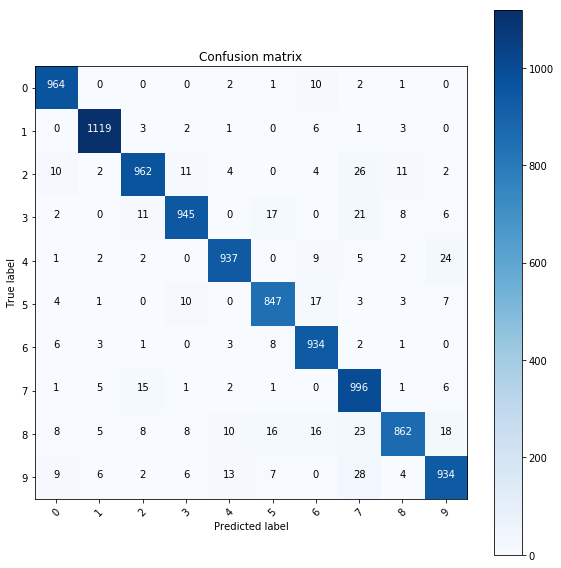

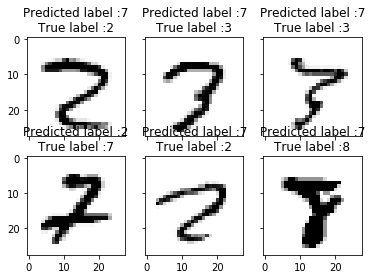

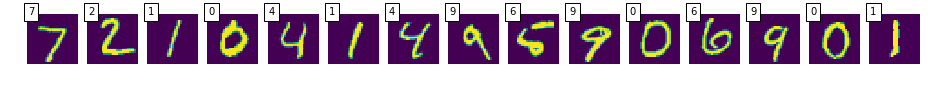

In [28]:
evaluate(X_test, Y_test, model)

---

# There's more:

The `GridSearchCV` model in scikit-learn performs a complete search, considering **all** the possible combinations of Hyper-parameters we want to optimise.

If we want to apply for an optmised and bounded search in the hyper-parameter space, I strongly suggest to take a look at:

* `Keras + hyperopt == hyperas`: [http://maxpumperla.github.io/hyperas/](http://maxpumperla.github.io/hyperas/)